In [3]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm
import astropy.units as u
from astropy.coordinates import SkyCoord, search_around_sky
import os

import matplotlib
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=21), plt.rc('ytick', labelsize=21)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [9]:
#1: SExtractor ID
#2 to 9: Aperture flux in the apertures with the following diameters: 
#3, 3.9, 2.8,3.7,4.8,5.8,8.2,11.6 arcsec [microJansky] :
#10 to 17; flux error  [microJansky] ;
#18 to 25: aperture magnitudes;
#26 to 33: aperture magnitudes errors;
#34,35: SExtractor AUTO flux and error [microJansky]; 
#36,37: SExtractor AUTO magnitude and error;
#38: Kron Radius (in units of A_IMAGE and B_IMAGE)l
#39, 40: X and Y position on the image [pixel];
#41, 42: RA and DEC [degree];
#43,44:  Isophotal image major and minor axis [pixel]
#45: position angle of the major axis [degree]
#46: Peak model surface brightness above the background [mag/arcsec2]
#47: FWHM_IMAGE [pixel]
#48: ELLIPTICITY (1-B_IMAGE/A_IMAGE)
#49: CLASS_STAR (star/galaxy classifier)
#50: Circular aperture radius enclosing half the total
# flux [pixel]

In [3]:
# trim shiraz catalogs
for band in ['CH1','CH2']:
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        if cat_name == 'COSMOS_deep':
            shiraz_cat_name = 'COSMOS_scosmos_ext'
        elif cat_name == 'DEEP_deep':
            shiraz_cat_name = 'DEEP23'
        elif cat_name == 'ELAIS_deep':
            shiraz_cat_name = 'EN1_lit'
            
        cat = Table.read('/Volumes/LejaySSD/SHIRAZ_catalogs/'+shiraz_cat_name+'_'+band+'_newfluxes_errmod.cat',format='ascii')
        cat = cat['ALPHA_J2000','DELTA_J2000','MAG_AUTO','MAGERR_AUTO']
        
        for key in cat.keys():
            if 'J2000' not in key:
                cat.rename_column(key,key+'_'+band)
        cat.write('/Volumes/LejaySSD/SHIRAZ_catalogs/trimmed_cats/'+cat_name+'_'+band+'_trim.fits',overwrite=True)

In [4]:
# match with CH1 and CH2 catalog

for cat_name in ['COSMOS','DEEP','ELAIS']:
    print(cat_name)
    
    # match with CH1
    my_cat_name = '/Users/lejay/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_deep_pcat_211221_mags_gals.fits'
    irac_cat_name = '/Volumes/LejaySSD/SHIRAZ_catalogs/trimmed_cats/'+cat_name+'_deep_CH1_trim.fits'
    combined_cat_name = my_cat_name.replace('.fits','_CH1_CH2.fits')
    
    cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0" join="all1"\
       in1='+ my_cat_name + ' values1="RA DEC" \
       in2='+ irac_cat_name + ' values2="ALPHA_J2000 DELTA_J2000" \
       out='+ combined_cat_name
    os.system(cmd)
    print('matched with CH1')
    
    # remove unnecessary columns
    cat_matched = Table.read(combined_cat_name)
    cat_matched.remove_columns(['ALPHA_J2000','DELTA_J2000'])
    cat_matched.write(my_cat_name.replace('.fits','_CH1_CH2.fits'), overwrite=True)   
    
    # match with CH2
    irac_cat_name = '/Volumes/LejaySSD/SHIRAZ_catalogs/trimmed_cats/'+cat_name+'_deep_CH2_trim.fits'
    cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0" join="all1"\
       in1='+ my_cat_name.replace('.fits','_CH1_CH2.fits') + ' values1="RA DEC" \
       in2='+ irac_cat_name + ' values2="ALPHA_J2000 DELTA_J2000" \
       out='+ combined_cat_name
    os.system(cmd)
    print('matched with CH2')
    
    # remove unnecessary columns
    cat_matched = Table.read(combined_cat_name)
    cat_matched.remove_columns(['ALPHA_J2000','DELTA_J2000'])
    cat_matched.write(my_cat_name.replace('.fits','_CH1_CH2.fits'), overwrite=True)  
    
    if cat_name == 'COSMOS':
        # match with COSMOS2020
        C20_cat_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits'
        col_list = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG HSC_i_MAGERR IRAC_CH1_MAG IRAC_CH1_MAGERR IRAC_CH2_MAG IRAC_CH2_MAGERR'"
        cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0" join="all1"\
           in1='+ combined_cat_name + ' values1="RA DEC" \
           in2='+ C20_cat_name + ' values2="ALPHA_J2000 DELTA_J2000" \
           out='+ combined_cat_name+' icmd2="keepcols '+col_list+'" '
        os.system(cmd)
        print('matched with C20')
        
        # remove unnecessary columns
        cat_matched = Table.read(combined_cat_name)    
        cat_matched.remove_columns(['ALPHA_J2000','DELTA_J2000'])
    
    print(cat_matched.keys())
    print('')
    
    cat_matched.write(my_cat_name.replace('.fits','_CH1_CH2.fits'), overwrite=True)  
    del cat_matched

COSMOS
matched with CH1
matched with CH2
matched with C20
['ID', 'RA', 'DEC', 'tract', 'patch', 'ZPHOT', 'ZPHOT_6B', 'ZPHOT_NIR', 'isCompact', 'inside_hsc', 'inside_u', 'inside_uS', 'inside_j', 'u_aper3', 'u_aper3_err', 'uS_aper3', 'uS_aper3_err', 'g_aper3', 'g_aper3_err', 'r_aper3', 'r_aper3_err', 'i_aper3', 'i_aper3_err', 'z_aper3', 'z_aper3_err', 'y_aper3', 'y_aper3_err', 'Yv_aper3', 'Yv_aper3_err', 'J_aper3', 'J_aper3_err', 'H_aper3', 'H_aper3_err', 'Ks_aper3', 'Ks_aper3_err', 'u', 'u_err', 'snr_u', 'uS', 'uS_err', 'snr_uS', 'g', 'g_err', 'snr_g', 'r', 'r_err', 'snr_r', 'i', 'i_err', 'snr_i', 'z', 'z_err', 'snr_z', 'y', 'y_err', 'snr_y', 'Yv', 'Yv_err', 'snr_Yv', 'J', 'J_err', 'snr_J', 'H', 'H_err', 'snr_H', 'Ks', 'Ks_err', 'snr_Ks', 'FUV', 'FUV_err', 'FUV_aper3', 'FUV_aper3_err', 'snr_FUV', 'NUV', 'NUV_err', 'NUV_aper3', 'NUV_aper3_err', 'snr_NUV', 'MAG_AUTO_CH1', 'MAGERR_AUTO_CH1', 'Separation_1', 'MAG_AUTO_CH2', 'MAGERR_AUTO_CH2', 'Separation_1a', 'HSC_i_MAG', 'HSC_i_MAGERR', 'I

In [5]:
cat = Table.read('/Users/lejay/phosphorus_catalogs/p_cats_v211221/COSMOS_deep_pcat_211221_mags_gals_CH1_CH2.fits')
cat = cat['RA','DEC','i','inside_u','HSC_i_MAG','MAG_AUTO_CH1','MAG_AUTO_CH2','IRAC_CH1_MAG','IRAC_CH2_MAG']
cat = cat[cat['i']<26]
cat = cat[cat['inside_u']==True]

cat = cat[cat['i']>0]
cat = cat[cat['HSC_i_MAG']>0]
cat = cat[cat['MAG_AUTO_CH1']>0]
cat = cat[cat['MAG_AUTO_CH2']>0]
cat = cat[cat['IRAC_CH1_MAG']>0]
cat = cat[cat['IRAC_CH2_MAG']>0]

cat = cat[cat['HSC_i_MAG']<90]
cat = cat[cat['MAG_AUTO_CH1']<90]
cat = cat[cat['IRAC_CH1_MAG']<90]
cat = cat[cat['MAG_AUTO_CH2']<90]
cat = cat[cat['IRAC_CH2_MAG']<90]
print(len(cat))

101392


In [6]:
# avoid source confusion

print('select only isolated galaxies (5 arcsec separation, 1mag difference)')
print('before',len(cat))

coords = SkyCoord(np.array(cat['RA']) * u.deg, np.array(cat['DEC']) * u.deg)
arr = search_around_sky(coords, coords, 10 / 3600 * u.deg)
sep2d, b = np.unique(np.round(arr[2], 10), return_index=True)  # only keep the unique pairs
arr0 = arr[0][b]
arr1 = arr[1][b]
gal1_list = arr0[sep2d.value > 0.01 / 3600]
gal2_list = arr1[sep2d.value > 0.01 / 3600]

remove_ids = []
for i in range(len(gal1_list)):
    if abs(cat[gal1_list[i]]['HSC_i_MAG'] - cat[gal2_list[i]]['HSC_i_MAG'])<1:
        remove_ids.append(gal1_list[i])
        remove_ids.append(gal2_list[i])

cat.remove_rows(remove_ids)
print('after',len(cat))

select only isolated galaxies (5 arcsec separation, 1mag difference)
before 101392
after 53873


#### calibrate ch1 ch2 with C20

In [7]:
def percentile_16(arr):
    return np.percentile(arr,16)

def percentile_84(arr):
    return np.percentile(arr,84)

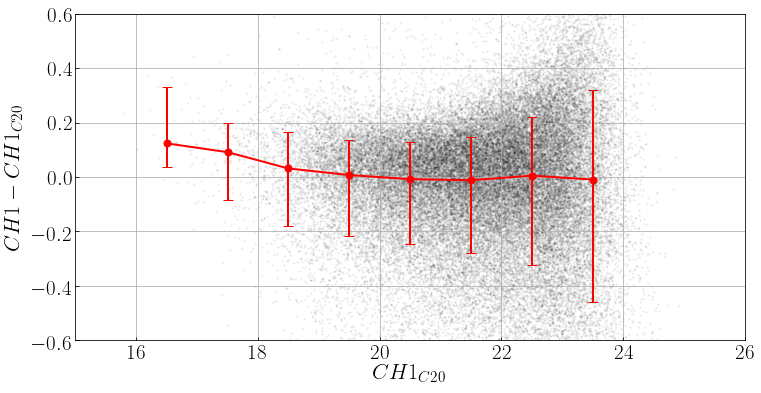

In [8]:
color_diff =  cat['MAG_AUTO_CH1']-cat['IRAC_CH1_MAG']
ch1_medians_ch1, ch1_bin_edges, ch1_bin_numbers = binned_statistic(cat['IRAC_CH1_MAG'], color_diff, statistic='median', bins=np.arange(16,24.5,1))
ch1_per16_ch1,   ch1_bin_edges, ch1_bin_numbers = binned_statistic(cat['IRAC_CH1_MAG'], color_diff, statistic=percentile_16, bins=np.arange(16,24.5,1))
ch1_per84_ch1,   ch1_bin_edges, ch1_bin_numbers = binned_statistic(cat['IRAC_CH1_MAG'], color_diff, statistic=percentile_84, bins=np.arange(16,24.5,1))

fig = plt.figure(figsize=(12,6))
plt.scatter(cat['IRAC_CH1_MAG'], color_diff, color='k', s=2, alpha=0.05)
plt.errorbar(ch1_bin_edges[:-1]+0.5, ch1_medians_ch1, yerr=[ch1_medians_ch1-ch1_per16_ch1,ch1_per84_ch1-ch1_medians_ch1],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
plt.xlabel('$CH1_{C20}$',fontsize=22)
plt.ylabel('$CH1-CH1_{C20}$',fontsize=22)
plt.xlim([15,26])
plt.ylim([-0.6,0.6])
plt.grid()
plt.show()

del color_diff

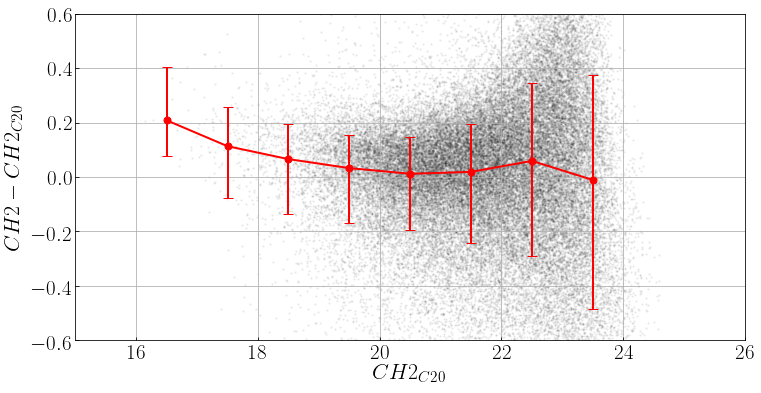

In [9]:
color_diff =  cat['MAG_AUTO_CH2']-cat['IRAC_CH2_MAG']
ch2_medians_ch2,ch2_bin_edges,ch2_bin_numbers = binned_statistic(cat['IRAC_CH2_MAG'], color_diff, statistic='median', bins=np.arange(16,24.5,1))
ch2_per16_ch2,bin_edges,ch2_bin_numbers = binned_statistic(cat['IRAC_CH2_MAG'], color_diff, statistic=percentile_16, bins=np.arange(16,24.5,1))
ch2_per84_ch2,bin_edges,ch2_bin_numbers = binned_statistic(cat['IRAC_CH2_MAG'], color_diff, statistic=percentile_84, bins=np.arange(16,24.5,1))

fig = plt.figure(figsize=(12,6))
plt.scatter(cat['IRAC_CH2_MAG'], color_diff,color='k',s=2, alpha=0.05)
plt.errorbar(ch2_bin_edges[:-1]+0.5,ch2_medians_ch2,yerr=[ch2_medians_ch2-ch2_per16_ch2,ch2_per84_ch2-ch2_medians_ch2],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
plt.xlabel('$CH2_{C20}$',fontsize=22)
plt.ylabel('$CH2-CH2_{C20}$',fontsize=22)
plt.xlim([15,26])
plt.ylim([-0.6,0.6])
plt.grid()
plt.show()

del color_diff

In [10]:
for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    print(cat_name)
    cat_irac_matched=Table.read('/Users/lejay/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_pcat_211221_mags_gals_CH1_CH2.fits')
    ch1_corr_list=[]
    ch2_corr_list=[]
    ch1_cali_err_list=[]
    ch2_cali_err_list=[]
    ch1_corr_err_list=[]
    ch2_corr_err_list=[]

    non_detect = 0
    for gal in tqdm(cat_irac_matched):
    
        # ch1
        if gal['MAG_AUTO_CH1']>-99:
            ch1_corr = gal['MAG_AUTO_CH1'] - np.interp(gal['MAG_AUTO_CH1'],bin_edges[:-1]+0.5,ch1_medians_ch1)
            ch1_phot_err = gal['MAGERR_AUTO_CH1']
            ch1_calib_err = (np.interp(gal['MAG_AUTO_CH1'],ch1_bin_edges[:-1]+0.5,ch1_per84_ch1) - np.interp(gal['MAG_AUTO_CH1'],ch1_bin_edges[:-1]+0.5,ch1_per16_ch1))/2
            ch1_corr_err = np.sqrt(ch1_phot_err**2 + ch1_calib_err**2)
            
            ch1_corr_list.append(ch1_corr)
            ch1_cali_err_list.append(ch1_calib_err)
            ch1_corr_err_list.append(ch1_corr_err)
        else:
            non_detect += 1
            ch1_corr_list.append(-99)
            ch1_cali_err_list.append(99)
            ch1_corr_err_list.append(99)
        
        # ch2
        if gal['MAG_AUTO_CH2']>-99:
            ch2_corr = gal['MAG_AUTO_CH2'] - np.interp(gal['MAG_AUTO_CH2'],bin_edges[:-1]+0.5,ch2_medians_ch2)
            ch2_phot_err = gal['MAGERR_AUTO_CH2']
            ch2_calib_err = (np.interp(gal['MAG_AUTO_CH2'],ch2_bin_edges[:-1]+0.5,ch2_per84_ch2) - np.interp(gal['MAG_AUTO_CH2'],ch2_bin_edges[:-1]+0.5,ch2_per16_ch2))/2
            ch2_corr_err = np.sqrt(ch2_phot_err**2 + ch2_calib_err**2)
            
            ch2_corr_list.append(ch2_corr)
            ch2_cali_err_list.append(ch2_calib_err)
            ch2_corr_err_list.append(ch2_corr_err)
        else:   
            ch2_corr_list.append(-99)
            ch2_cali_err_list.append(99)
            ch2_corr_err_list.append(99)
    
    print(non_detect)
    print(len(cat_irac_matched))
    
    ch1_corr_col = Column(name='MAG_AUTO_CH1_CORR', data=np.array(ch1_corr_list))
    ch2_corr_col = Column(name='MAG_AUTO_CH2_CORR', data=np.array(ch2_corr_list))
    ch1_cali_err_col = Column(name='MAGERR_AUTO_CH1_CALI', data=np.array(ch1_cali_err_list))
    ch2_cali_err_col = Column(name='MAGERR_AUTO_CH2_CALI', data=np.array(ch2_cali_err_list))
    ch1_corr_err_col = Column(name='MAGERR_AUTO_CH1_CORR', data=np.array(ch1_corr_err_list))
    ch2_corr_err_col = Column(name='MAGERR_AUTO_CH2_CORR', data=np.array(ch2_corr_err_list))
    cat_irac_matched.add_columns([ch1_corr_col,ch2_corr_col,ch1_cali_err_col,ch2_cali_err_col,ch1_corr_err_col,ch2_corr_err_col])
    print('column added')
    
    cat_irac_matched.write('/Users/lejay/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_pcat_211221_mags_gals_CH1_CH2_corr.fits', overwrite=True)
    del cat_irac_matched

COSMOS_deep


100%|██████████| 2959280/2959280 [00:19<00:00, 149016.26it/s]


2535111
2959280
column added
DEEP_deep


100%|██████████| 1950218/1950218 [00:14<00:00, 133774.19it/s]


1635970
1950218
column added
ELAIS_deep


100%|██████████| 2132437/2132437 [00:16<00:00, 127985.68it/s]


1749997
2132437
column added


#### correct for Galactic extinction and add mag_offset flag

In [11]:
from __future__ import print_function
import astropy.units as units
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery


In [12]:
# u, uS, g, r, i, z, y
coef = [4.1382,4.008,3.2582,2.2864,1.6412,1.2641,1.0808]
sfd = SFDQuery()

for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep']:
    print(cat_name)
    if cat_name != 'XMM-LSS_deep':
        cat = Table.read('/Users/lejay/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_pcat_211221_mags_gals_CH1_CH2_corr.fits')
    else:
        cat = Table.read('/Users/lejay/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_pcat_211221_mags_gals.fits')
    
    for i,band in enumerate(['u','uS','g','r','i','z','y']):
        coords = SkyCoord(cat['RA']*units.deg,  cat['DEC']*units.deg)
        ebv = sfd(coords)
        corr  = coef[i]*ebv
        cat[band] = cat[band] - corr
    
    for key in cat.keys():
        if 'ZPHOT' in key:
            cat.rename_column(key,key.replace('ZPHOT','ZPHOT_G'))
        if 'Separation' in key:
            cat.remove_column(key)
    
    mag_offset_flags = np.ones(len(cat))
    for band in ['g','r','i','z','y']:
        mag_offset_flag = (abs(cat[band+'_aper3']-cat[band])>1.5).astype(int)
        mag_offset_flags = np.vstack([mag_offset_flags,mag_offset_flag])
    
    # add columnfor mag offset flag
    mag_offset_flags = np.delete(mag_offset_flags, (0), axis=0)
    mag_offset_flagsum = np.sum(mag_offset_flags,axis=0)
    col_mag_offset = Column(name='mag_offset_flag',data=mag_offset_flagsum)
    if 'mag_offset_flag' in cat.keys():
        cat.remove_column('mag_offset_flag')
    cat.add_column(col_mag_offset)
    
    # save the extinction correted catalog with a different name
    cat.write('/Users/lejay/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_pcat_mags_gals_CH1_CH2_extinction_corrected.fits', overwrite=True)
    del cat

COSMOS_deep
DEEP_deep
ELAIS_deep
XMM-LSS_deep
